<a href="https://colab.research.google.com/github/asifsiraz/ML-projects/blob/main/project(SCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Layer 1: 255 active nodes
Layer 2: 126 active nodes
Layer 3: 59 active nodes
Layer 4: 10 active nodes
Epoch 1/10


750/750 [==============================] - 11s 11ms/step - loss: 0.7475 - accuracy: 0.8390 - val_loss: 0.4434 - val_accuracy: 0.9225
Epoch 2/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4089 - accuracy: 0.9271 - val_loss: 0.3938 - val_accuracy: 0.9334
Epoch 3/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3635 - accuracy: 0.9358 - val_loss: 0.3440 - val_accuracy: 0.9396
Epoch 4/10
750/750 [==============================] - 8s 10ms/step - loss: 0.3737 - accuracy: 0.9336 - val_loss: 0.3411 - val_accuracy: 0.9425
Epoch 5/10
750/750 [==============================] - 9s 12ms/step - loss: 0.3171 - accuracy: 0.9461 - val_loss: 0.3084 - val_accuracy: 0.9486
Epoch 6/10
750/750 [==============================] - 9s 12ms/step - loss: 0.2807 - accuracy: 0.9531 - val_loss: 0.3012 - val_accuracy: 0.9462
Epoch 7/10
750/750 [==============================] - 8s 11ms/step - loss: 0.2783 - accuracy: 0.9521 - val_loss: 0.3012 - val_accuracy: 0.9455
Epoch 8/1

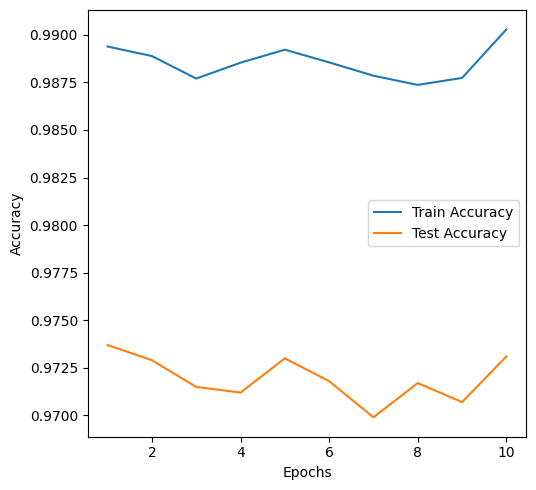

In [34]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.regularizers import l1
import time

import warnings
warnings.filterwarnings("ignore") # Ignore warnings


# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Custom layer for modified batch normalization
class PercentileBatchNormalization(layers.BatchNormalization):
    def call(self, inputs, training=None):
        # Compute the percentile (90th percentile) along the last axis (batch axis)
        percentiles = tfp.stats.percentile(inputs, 90, axis=0)
        # Subtract the percentile from the inputs and normalize as in batch normalization
        normalized_inputs = (inputs - percentiles) / (tf.math.reduce_std(inputs, axis=0) + self.epsilon)
        return normalized_inputs

# Define the model with modified batch normalization and ReLU activation, and L1 regularization
def create_model_with_l1_and_modified_bn():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(256, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)),
        PercentileBatchNormalization(),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)),
        PercentileBatchNormalization(),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)),
        PercentileBatchNormalization(),
        layers.Dense(10, activation='softmax', activity_regularizer=l1(0.001))
    ])
    return model

learning_rate = 0.001

# Train the model with L1 regularization and modified batch normalization
model_with_l1_and_modified_bn = create_model_with_l1_and_modified_bn()
model_with_l1_and_modified_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a sample batch for the forward pass
sample_batch_flattened = train_images[:64].reshape(64, -1)

# Calculate the number of active nodes for each layer using forward pass
def calculate_active_nodes(model, x):
    active_nodes_counts = []
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            # Perform forward pass
            x = layer(x)
            # Identify active nodes (non-zero activations) for the current layer
            active_nodes = np.sum(np.any(x.numpy() != 0, axis=0))
            active_nodes_counts.append(active_nodes)
    return active_nodes_counts

active_nodes_counts = calculate_active_nodes(model_with_l1_and_modified_bn, sample_batch_flattened)
for i, count in enumerate(active_nodes_counts, start=1):
    print(f"Layer {i}: {count} active nodes")


# Measure the time taken to train the model
start_time = time.time()

model_with_l1_and_modified_bn.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

end_time = time.time()
training_time = end_time - start_time
print("Time taken to train the model:", training_time, "seconds")


# Calculate the percentage of active nodes for each layer using forward pass
def calculate_active_nodes_percentages(model, x):
    active_nodes_percentages = []
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            # Perform forward pass
            x = layer(x)
            # Identify active nodes (non-zero activations) for the current layer
            active_nodes = np.sum(np.any(x.numpy() != 0, axis=0))
            total_nodes = x.shape[-1]
            active_nodes_percentage = (active_nodes / total_nodes) * 100
            active_nodes_percentages.append(active_nodes_percentage)
    return active_nodes_percentages

active_nodes_percentages = calculate_active_nodes_percentages(model_with_l1_and_modified_bn, sample_batch_flattened)
for i, percentage in enumerate(active_nodes_percentages, start=1):
    print(f"Layer {i}: {percentage:.2f}% active nodes")


# Lists to store performance and sparsity across learning
train_accuracies = []
test_accuracies = []


# Train the model for multiple epochs and track performance and sparsity
epochs = 10
for epoch in range(epochs):
    model_with_l1.fit(train_images, train_labels, epochs=1, batch_size=64, validation_split=0.2, verbose=0)

    # Evaluate the model on training data
    _, train_accuracy = model_with_l1.evaluate(train_images, train_labels, verbose=0)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on test data
    _, test_accuracy = model_with_l1.evaluate(test_images, test_labels, verbose=0)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Train accuracy: {train_accuracy:.4f} - Test accuracy: {test_accuracy:.4f} ")

# Plot the performance and sparsity across learning
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()



Layer 1: 252 active nodes
Layer 2: 127 active nodes
Layer 3: 59 active nodes
Layer 4: 10 active nodes
Epoch 1/10
750/750 [==============================] - 11s 12ms/step - loss: 0.8689 - accuracy: 0.8038 - val_loss: 0.4961 - val_accuracy: 0.9071
Epoch 2/10
750/750 [==============================] - 9s 12ms/step - loss: 0.4531 - accuracy: 0.9160 - val_loss: 0.3957 - val_accuracy: 0.9312
Epoch 3/10
750/750 [==============================] - 9s 12ms/step - loss: 0.3745 - accuracy: 0.9336 - val_loss: 0.3737 - val_accuracy: 0.9335
Epoch 4/10
750/750 [==============================] - 8s 11ms/step - loss: 0.3755 - accuracy: 0.9312 - val_loss: 0.3637 - val_accuracy: 0.9373
Epoch 5/10
750/750 [==============================] - 9s 12ms/step - loss: 0.3436 - accuracy: 0.9397 - val_loss: 0.3387 - val_accuracy: 0.9422
Epoch 6/10
750/750 [==============================] - 9s 12ms/step - loss: 0.3517 - accuracy: 0.9371 - val_loss: 0.3651 - val_accuracy: 0.9349
Epoch 7/10
750/750 [===================

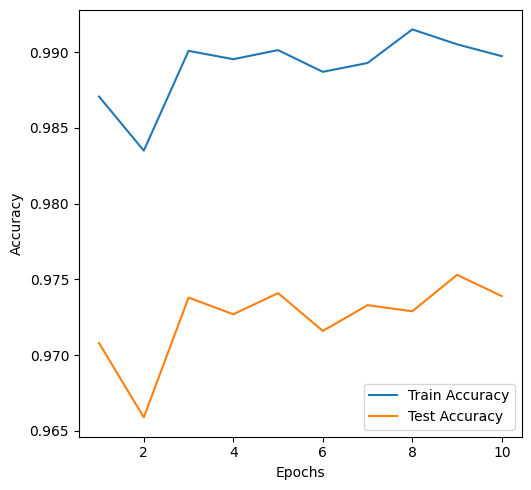

In [35]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets
from tensorflow.keras.regularizers import l1
import time

import warnings
warnings.filterwarnings("ignore")

# Load MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0




# Custom layer for modified batch normalization
class PercentileBatchNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(PercentileBatchNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def call(self, inputs, training=None):
        # Compute the percentile (90th percentile) along the last axis (batch axis)
        percentiles = tfp.stats.percentile(inputs, 90, axis=0)
        # Subtract the percentile from the inputs and normalize as in batch normalization
        normalized_inputs = (inputs - percentiles) / (tf.math.reduce_std(inputs, axis=0) + self.epsilon)
        return normalized_inputs

    def get_config(self):
        config = super(PercentileBatchNormalization, self).get_config()
        config.update({"epsilon": self.epsilon})
        return config


# Define the model with modified batch normalization and ReLU activation, and L1 regularization
def create_model_with_l1_and_modified_bn():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(256, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)),
        PercentileBatchNormalization(),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)),
        PercentileBatchNormalization(),
        layers.Dense(64, activation='relu', kernel_initializer='he_normal', activity_regularizer=l1(0.001)),
        PercentileBatchNormalization(),
        layers.Dense(10, activation='softmax', activity_regularizer=l1(0.001))
    ])
    return model

learning_rate = 0.001

# Train the model with L1 regularization and modified batch normalization
model_with_l1_and_modified_bn = create_model_with_l1_and_modified_bn()
model_with_l1_and_modified_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create a sample batch for the forward pass
sample_batch_flattened = train_images[:64].reshape(64, -1)

# Calculate the number of active nodes for each layer using forward pass
def calculate_active_nodes(model, x):
    active_nodes_counts = []
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            # Perform forward pass
            x = layer(x)
            # Identify active nodes (non-zero activations) for the current layer
            active_nodes = np.sum(np.any(x.numpy() != 0, axis=0))
            active_nodes_counts.append(active_nodes)
    return active_nodes_counts

active_nodes_counts = calculate_active_nodes(model_with_l1_and_modified_bn, sample_batch_flattened)
for i, count in enumerate(active_nodes_counts, start=1):
    print(f"Layer {i}: {count} active nodes")


# Measure the time taken to train the model
start_time = time.time()

model_with_l1_and_modified_bn.fit(train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2)

end_time = time.time()
training_time = end_time - start_time
print("Time taken to train the model:", training_time, "seconds")


# Calculate the percentage of active nodes for each layer using forward pass
def calculate_active_nodes_percentages(model, x):
    active_nodes_percentages = []
    for layer in model.layers:
        if isinstance(layer, layers.Dense):
            # Perform forward pass
            x = layer(x)
            # Identify active nodes (non-zero activations) for the current layer
            active_nodes = np.sum(np.any(x.numpy() != 0, axis=0))
            total_nodes = x.shape[-1]
            active_nodes_percentage = (active_nodes / total_nodes) * 100
            active_nodes_percentages.append(active_nodes_percentage)
    return active_nodes_percentages

active_nodes_percentages = calculate_active_nodes_percentages(model_with_l1_and_modified_bn, sample_batch_flattened)
for i, percentage in enumerate(active_nodes_percentages, start=1):
    print(f"Layer {i}: {percentage:.2f}% active nodes")


# Lists to store performance
train_accuracies = []
test_accuracies = []


# Train the model for multiple epochs and track performance
epochs = 10
for epoch in range(epochs):
    model_with_l1.fit(train_images, train_labels, epochs=1, batch_size=64, validation_split=0.2, verbose=0)

    # Evaluate the model on training data
    _, train_accuracy = model_with_l1.evaluate(train_images, train_labels, verbose=0)
    train_accuracies.append(train_accuracy)

    # Evaluate the model on test data
    _, test_accuracy = model_with_l1.evaluate(test_images, test_labels, verbose=0)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Train accuracy: {train_accuracy:.4f} - Test accuracy: {test_accuracy:.4f} ")

# Plot the performance
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()
